# Reducción de dimensionalidad para machine learning en Python
En este taller vamos a tener una vista general de como reducir las dimensiones de unos datos utilizando las librerias de Pandas y scitkit-learn. El objetivo es entender el proceso tipico y también ver unas aplicaciones de reducción de dimensiones.

In [1]:
import pandas as pd
import plotnine as pn
from mizani.formatters import percent_format
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from pca import pca
from matplotlib import pyplot as plt

data_location = 'tweet_and_user_data.csv'

pd.options.display.max_columns = 500

In [2]:
tweet_data = pd.read_csv(data_location)

/Users/andreas/miniforge3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.


In [3]:
tweet_data.shape

(40581, 56)

In [4]:
tweet_data.head()

,id,conversation_id,created_at,date,timezone,place,tweet,language,hashtags,cashtags,user_id,user_id_str,username,name,day,hour,link,urls,photos,video,thumbnail,retweet,nlikes,nreplies,nretweets,quote_url,search,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest,id_user,name_user,username_user,bio,url,join_datetime,join_date,join_time,tweets,location,following,followers,likes,media,private,verified,avatar,background_image
0,1425590913959612419,1425590913959612419,1.628722e+12,2021-08-12 00:52:14,200,NaN,RT @girlsalliance: We're so proud of the four ...,en,[],[],409486555,409486555,MichelleObama,Michelle Obama,4,0,https://twitter.com/MichelleObama/status/14255...,[],[],0,NaN,True,0,0,232,0,None,NaN,NaN,NaN,1.047165e+18,We're so proud of the four organizations in ou...,1.425590e+18,[],2021-08-12 00:46:58 CEST,NaN,NaN,NaN,409486555,Michelle Obama,MichelleObama,Girl from the South Side and former First Lady...,https://t.co/HPYP9ad13Y,2011-11-10 20:13:01 UTC,2011-11-10,20:13:01 UTC,1770,"Washington, DC",16,20854298,184,461,False,True,https://pbs.twimg.com/profile_images/136674780...,https://pbs.twimg.com/profile_banners/40948655...
1,1427736867739299841,1427736867739299841,1.629234e+12,2021-08-17 22:59:29,200,NaN,Some casual suggestions to 😏SLIDE😏 into when u...,en,"['shoesdaytuesday', 'afterskewlslide']",[],21447363,21447363,katyperry,KATY PERRY,2,22,https://twitter.com/katyperry/status/142773686...,[],['https://pbs.twimg.com/media/E9BXG4YVkAAl3_A....,1,https://pbs.twimg.com/media/E9BXG4YVkAAl3_A.jpg,False,5266,368,408,0,None,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,21447363,KATY PERRY,katyperry,Love. Light.,https://t.co/Rrwt0Kj2Q7,2009-02-20 23:45:56 UTC,2009-02-20,23:45:56 UTC,11420,NaN,235,108819032,7995,2170,False,True,https://pbs.twimg.com/profile_images/139246535...,https://pbs.twimg.com/profile_banners/21447363...
2,1427667300488937476,1427667300488937476,1.629217e+12,2021-08-17 18:23:03,200,NaN,RT @ValaAfshar: You are not your job.,en,[],[],21447363,21447363,katyperry,KATY PERRY,2,18,https://twitter.com/katyperry/status/142766730...,[],[],0,NaN,True,0,0,764,0,None,NaN,NaN,NaN,2.597252e+08,You are not your job.,1.427648e+18,[],2021-08-17 17:05:53 CEST,NaN,NaN,NaN,21447363,KATY PERRY,katyperry,Love. Light.,https://t.co/Rrwt0Kj2Q7,2009-02-20 23:45:56 UTC,2009-02-20,23:45:56 UTC,11420,NaN,235,108819032,7995,2170,False,True,https://pbs.twimg.com/profile_images/139246535...,https://pbs.twimg.com/profile_banners/21447363...
3,1427667012105371652,1427667012105371652,1.629217e+12,2021-08-17 18:21:55,200,NaN,What have we become 😔😂 Toddler Cites Freedom ...,en,[],[],21447363,21447363,katyperry,KATY PERRY,2,18,https://twitter.com/katyperry/status/142766701...,['https://www.theonion.com/toddler-cites-freed...,[],0,NaN,False,5638,476,438,0,None,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,21447363,KATY PERRY,katyperry,Love. Light.,https://t.co/Rrwt0Kj2Q7,2009-02-20 23:45:56 UTC,2009-02-20,23:45:56 UTC,11420,NaN,235,108819032,7995,2170,False,True,https://pbs.twimg.com/profile_images/139246535...,https://pbs.twimg.com/profile_banners/21447363...
4,1427497703596990467,1427497703596990467,1.629177e+12,2021-08-17 07:09:08,200,NaN,The tech giants that refuse to massively addre...,en,[],[],21447363,21447363,katyperry,KATY PERRY,2,7,https://twitter.com/katyperry/status/142749770...,[],[],0,NaN,False,8810,546,1211,https://twitter.com/VICENews/status/1427311204...,None,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,21447363,KATY PERRY,katyperry,Love. Light.,https://t.co/Rrwt0Kj2Q7,2009-02-20 23:45:56 UTC,2009-02-20,23:45:56 UTC,11420,NaN,235,108819032,7995,2170,False,True,https://pbs.twimg.com/profile_images/139246535...,https://pbs.twimg.com/profile_banners/21447363...


Vamos a transformar nuestro base de datos de tweets en un conjunto orientado a los usuarios. Para esto vamos a agregar agrupando por los usuarios, primero creando unas variables. Luego utilizaremos la reducción de dimensiones para facilitar el analisis de estos usuarios.

In [5]:
tweet_data['number_hashtags'] = tweet_data.hashtags.str.count(',')
tweet_data['num_replies_to'] = tweet_data.reply_to.str.count('{')
tweet_data['num_photos'] = tweet_data.photos.str.count(',')
tweet_data['num_urls'] = tweet_data.urls.str.count(',')

tweet_data['tweet_length'] = tweet_data.tweet.str.len()

In [6]:
unique = ['id', 'conversation_id', 'retweet_id']
avg = ['nlikes', 'nreplies', 'nretweets', 'number_hashtags', 'num_replies_to', 'num_photos', 'num_urls']

gby = ['id_user', 'name_user', 'bio', 'join_date', 'following', 'followers', 'likes', 'tweets', 'media', 'location', 'verified']

agg = {col : 'nunique' if col in unique else 'mean' for col in unique + avg}

tweet_data['location'] = tweet_data.location.fillna('')

user_stats = tweet_data.groupby(gby).agg(agg).reset_index()

# Media de likes etc. para sus posts del pasado
user_stats['avg_likes'] = user_stats.likes / user_stats.tweets
user_stats['avg_media'] = user_stats.media / user_stats.tweets
user_stats['followers_per_tweet'] = user_stats.followers / user_stats.tweets
user_stats['num_days_created'] = (pd.to_datetime('2022-01-01') - pd.to_datetime(user_stats.join_date)).dt.days
user_stats['bio_length'] = user_stats.bio.str.len()

In [7]:
user_stats.head()

,id_user,name_user,bio,join_date,following,followers,likes,tweets,media,location,verified,id,conversation_id,retweet_id,nlikes,nreplies,nretweets,number_hashtags,num_replies_to,num_photos,num_urls,avg_likes,avg_media,followers_per_tweet,num_days_created,bio_length
0,12,jack⚡️,#bitcoin,2006-03-21,4406,5656510,35242,27756,2836,,True,74,48,18,1699.081081,155.418919,574.175676,0.0,1.445946,0.027027,0.000000,1.269707,0.102176,203.794135,5765,8
1,13,Biz Stone,I’m a regular Joe but my name is Biz.,2006-03-21,1596,2669130,7152,9768,911,"San Francisco, CA",True,7,5,1,13.000000,1.714286,1.714286,0.0,0.714286,0.000000,0.000000,0.732187,0.093264,273.252457,5765,37
2,428333,CNN Breaking News,Breaking news from CNN Digital. Now 61M strong...,2007-01-02,119,61197525,27,75870,17019,Everywhere,True,66,65,1,1631.545455,417.424242,424.303030,0.0,0.000000,0.000000,0.000000,0.000356,0.224318,806.610320,5478,157
3,717313,Ars Technica,"Original news, reviews, analysis of tech trend...",2007-01-28,1330,1147218,8425,118653,6238,NYC - Boston - Chicago - SF,True,111,111,11,22.675676,1.702703,10.153153,0.0,0.000000,0.000000,0.000000,0.071005,0.052573,9.668681,5452,107
4,742143,BBC News (World),"News, features and analysis from the World's n...",2007-02-01,18,32526661,13,332018,25403,"London, UK",True,441,436,65,734.868481,103.995465,296.519274,0.0,0.000000,0.000000,0.002268,0.000039,0.076511,97.966559,5448,138


In [8]:
user_stats.shape, user_stats.id_user.nunique()

((796, 26), 796)

## El primer PCA
PCA es una de las grandes tecnicas para hacer reducción de dimensiones. Vamos a empezar aquí para ver el sintaxis de scikit-learn y entender exactamente que es el PCA.

In [9]:
variables = [col for col in user_stats if user_stats[col].dtypes in [int, float] and col not in ['id_user']]

I think maybe take the approach of grabbing all the components and simply progressing from there - focusing on how much we capture

In [10]:
pca_pipeline = Pipeline(
    [
        ('scaler', preprocessing.StandardScaler()),
        ('pca', PCA(random_state=0))
    ]
)

pca_pipeline.fit(user_stats[variables])

transformed_data = pd.DataFrame(pca_pipeline.transform(user_stats[variables]))
transformed_data.columns = [f'component_{i+1}' for i in range(transformed_data.shape[1])]

In [11]:
transformed_data

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,component_11,component_12,component_13,component_14,component_15,component_16,component_17,component_18,component_19,component_20
0,0.316859,-0.424299,2.324607,0.277264,-2.060014,1.048841,-0.285958,0.371953,1.176407,1.336149,0.246896,-0.429459,1.455417,-0.233486,-0.403052,0.028637,0.353318,-0.108595,-0.006576,0.029970
1,-0.462513,-0.514690,1.078425,-0.409850,-1.719207,0.687969,0.081162,0.538256,0.285983,0.731850,-0.599261,-0.513946,1.281090,0.114890,-0.059085,-0.021072,0.216331,-0.155564,0.010878,-0.022950
2,0.940947,0.548988,-0.673632,0.958332,-2.082091,-0.221178,1.965827,0.474597,0.543838,-1.332907,-1.692363,1.033233,-1.421472,-1.654752,0.505090,-0.120198,0.038139,0.152241,-0.114846,0.004904
3,1.383151,-0.358575,0.569973,-1.075526,-0.740132,0.105592,0.454027,0.314204,-0.374153,-0.429078,-0.924401,0.222707,0.497714,0.647185,-0.238928,-0.135174,0.066600,0.642764,0.032103,-0.013100
4,6.500794,0.631367,0.165577,-0.453968,-1.445286,0.162598,0.842171,0.017936,0.191168,-1.438165,0.212704,1.770538,-0.378034,0.035072,0.526425,-0.332054,0.190590,1.997584,-0.010420,-0.082612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
791,-1.413062,0.016427,-1.152675,0.710434,2.823134,-1.119355,-2.236795,-1.196946,-0.132571,0.958762,1.823343,-0.418679,-1.844104,-0.314256,0.593394,0.097260,-0.093307,0.286971,-0.047171,-0.006530
792,-1.355287,0.184307,-1.401139,0.705201,2.771011,-2.388670,-2.638525,-1.647992,0.248454,-0.120825,2.531612,0.160019,-2.743208,0.332593,0.421335,0.132507,-0.405591,0.007907,-0.101946,-0.009354
793,-1.702429,1.409381,-1.774401,1.847495,2.739430,-3.031465,-2.298748,-1.668093,0.750537,-0.913644,2.250159,0.453289,-2.577863,1.073160,0.235592,0.700470,-0.389675,0.039417,-0.074730,-0.024481
794,-2.014884,0.771230,-2.425037,3.020503,2.957236,-3.300816,-2.476854,-1.675471,0.888109,-1.016511,2.314955,0.482245,-1.548141,2.218800,-0.342245,0.117787,-0.915236,0.093832,-0.043428,0.006988


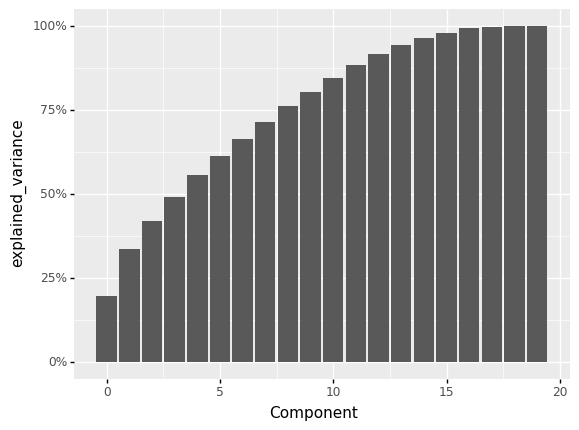

In [12]:
graph_data = pd.DataFrame(pca_pipeline['pca'].explained_variance_ratio_.cumsum(), columns=['explained_variance']).reset_index()

graph = pn.ggplot(graph_data, pn.aes(x='index', y='explained_variance')) + pn.geom_col() + pn.xlab('Component') + pn.scale_y_continuous(labels=percent_format())
graph.draw();

Cuando no especificamos ningún número de componentes el PCA devuelve todos los posibles. Visualizamos cuanto de la varianza cada componente explica y vemos que los primeros son los más importantes y luego cada uno aporta menos información.

Vamos a intentar visualizar datos en terminos de los diferentes componentes en un grafico.

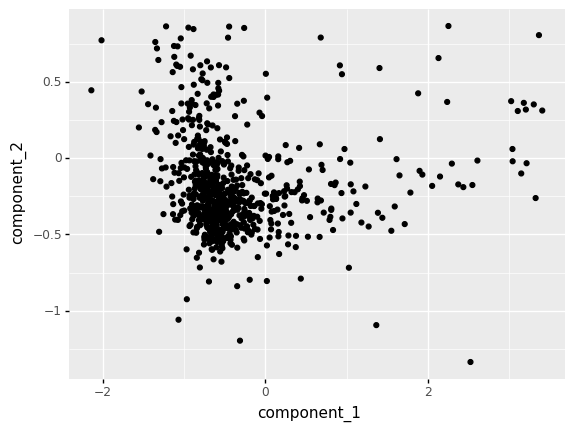

In [13]:
limit_x = transformed_data.component_1.quantile(0.95)
limit_y = transformed_data.component_2.quantile(0.95)

condition = (transformed_data.component_1 < limit_x) & (transformed_data.component_2 < limit_y)

graph = (
    pn.ggplot(transformed_data[condition], pn.aes(x='component_1', y='component_2'))
    + pn.geom_point()
)

graph.draw();

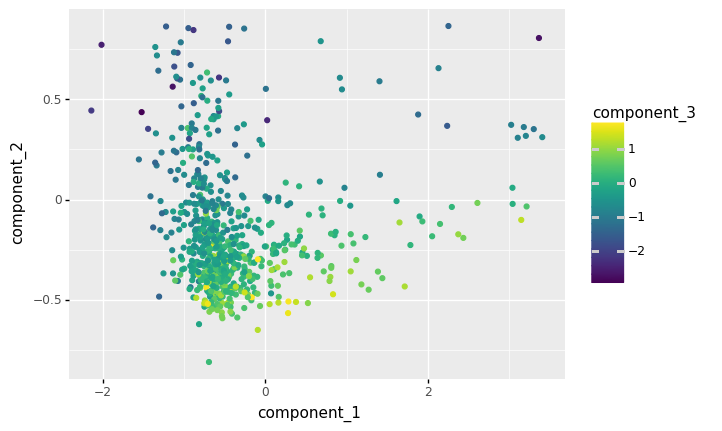

In [14]:
limit_x = transformed_data.component_1.quantile(0.95)
limit_y = transformed_data.component_2.quantile(0.95)
limit_z = transformed_data.component_3.quantile(0.95)

condition = (transformed_data.component_1 < limit_x) & (transformed_data.component_2 < limit_y) & (transformed_data.component_3 < limit_z)

graph = (
    pn.ggplot(transformed_data[condition], pn.aes(x='component_1', y='component_2', color='component_3'))
    + pn.geom_point()
)

graph.draw();

Apreciamos que algunos de los datos se ubican en las partes extremas de estos primeros componentes.

Que relacion tienen los componentes con nuestras variables iniciales? Para esto tenemos el biplot. Para visualizarlo, vamos a aprovechar de una libreria que se llama "PCA".

In [15]:
model = pca(n_components=3)
scaler = preprocessing.StandardScaler()
results = model.fit_transform(scaler.fit_transform(user_stats[variables]))

[pca] >Column labels are auto-completed.
[pca] >Row labels are auto-completed.
[pca] >The PCA reduction is performed on the [20] columns of the input dataframe.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[3]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


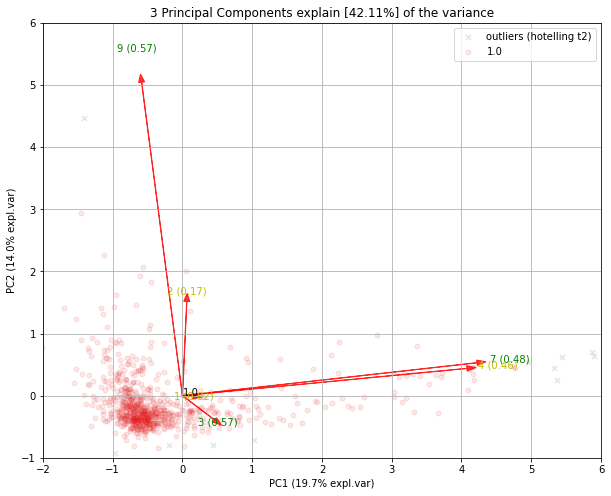

In [16]:
fig, ax = model.biplot(n_feat=6, alpha_transparency=0.1, hotellingt2=True, visible=False)
ax.set_xlim([-2, 6])
ax.set_ylim([-1, 6])
fig.set_visible(True)

Las flechas indican nuestras variables iniciales y podemos entender que ciertas variables tienen una correlacion alta con los componentes. Esto ayuda en explicar que variables son las más importantes a la hora de explicar la varianza.

/Users/andreas/miniforge3/lib/python3.9/site-packages/pca/pca.py:867: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.


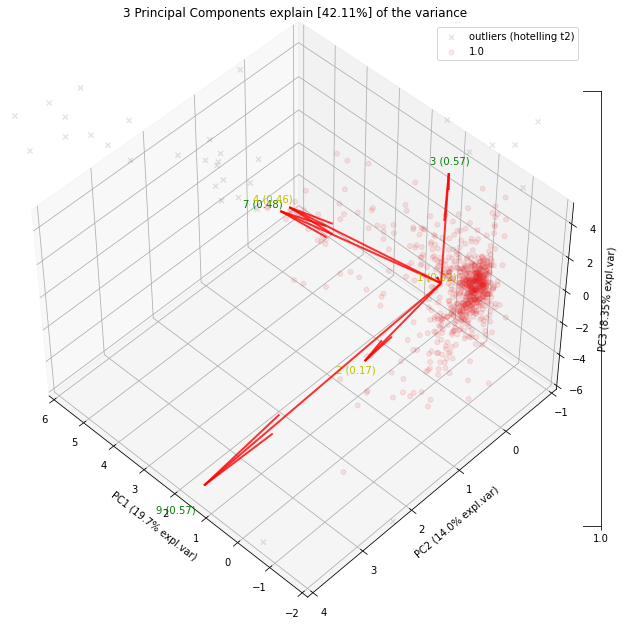

In [17]:
fig, ax = model.biplot(n_feat=6, alpha_transparency=0.1, hotellingt2=True, d3=True, visible=False)
ax.set_xlim([-2, 6])
ax.set_ylim([-1, 4])
ax.set_zlim([-6, 5])
fig.set_visible(True)

In [18]:
nums = [2, 3, 4, 7, 9]
[(num, variables[num]) for num in nums]

[(2, 'likes'), (3, 'tweets'), (4, 'media'), (7, 'retweet_id'), (9, 'nreplies')]

Aquí vemos lo mismo pero en 3D. Entendemos que nuestros primeros 3 componentes principalmente se definen por:

* El número de retweets
* El número de respuestas de media
* El número de tweets

Esto es bastante interesante porque corresponde bien con 3 tipos de tweet diferente que se puede hacer, en general. Entonces entendemos que nuestro conjunto de usuarios principalmente se explican por estas variables.

## T-SNE
El algoritmo de t-SNE crea una descripción de nuestros datos en un embedding de tipicamente 2 o 3 dimensiones. Esto nos permite visualizar datos de altas dimensiones en un espacio reducido. Generalmente se recomienda aplicar un PCA primero para mejorar el rendimiento del algoritmo. Con nuestros datos seguramente no hará mucha diferencia pero lo haremos para mostrar cómo.

In [38]:
ncomponents = 2
tsne_pipeline = Pipeline(
    [
        ('scaler', preprocessing.StandardScaler()),
        ('pca', PCA(random_state=0)),
        ('tsne', TSNE(ncomponents, random_state=0))
    ]
)

cols = ['component_' + str(i + 1) for i in range(ncomponents)]
transformed_data = pd.DataFrame(tsne_pipeline.fit_transform(user_stats[variables]), columns=cols)

/Users/andreas/miniforge3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
/Users/andreas/miniforge3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.


In [39]:
transformed_data = pd.concat([transformed_data, user_stats[['name_user'] + variables]], axis=1)

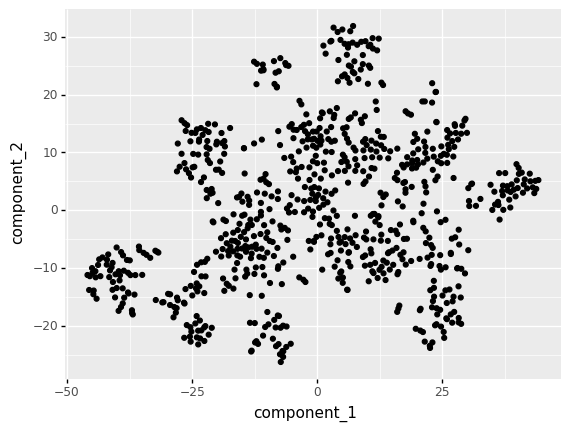

In [40]:
graph = (
    pn.ggplot(transformed_data, pn.aes(x='component_1', y='component_2'))
    + pn.geom_point()
)

graph.draw();

Vemos cómo ahora tenemos una distribucion en 2 dimensiones bastante diferente a antes. En vez de estar todos los puntos concentrados en unas pocas partes del grafico, tenemos una distribucion mejor. Esto es gracias al algortmo que busca separar puntos diferentes y juntar puntos similares.

Vamos a poner un color a los puntos que corresponde a las variables que vimos que eran importantes antes.

/Users/andreas/miniforge3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
/Users/andreas/miniforge3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
/Users/andreas/miniforge3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log


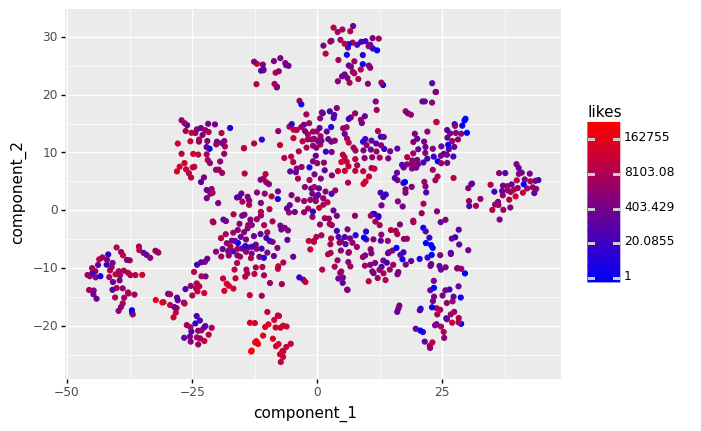

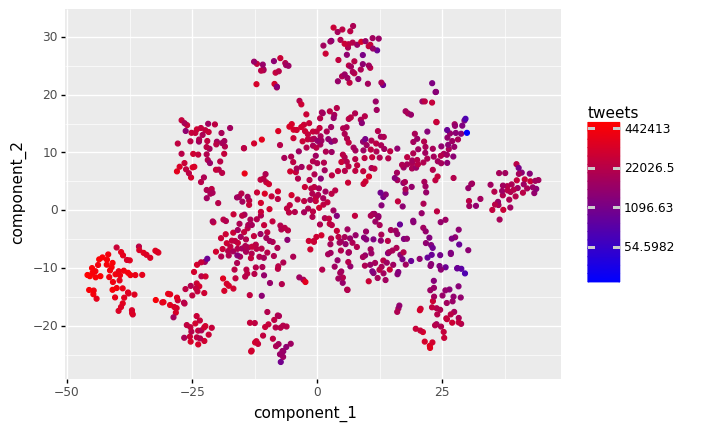

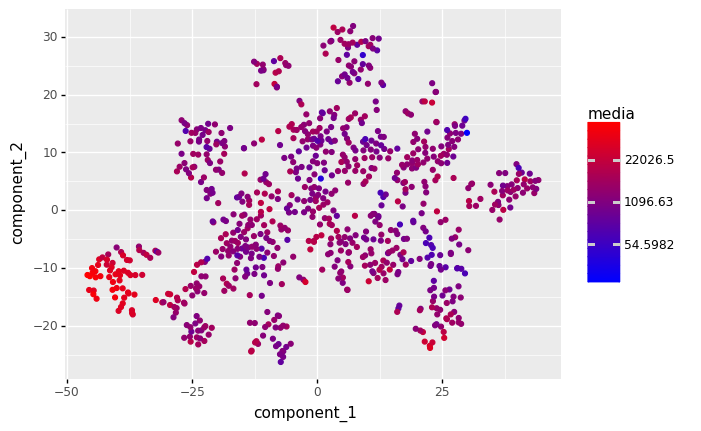

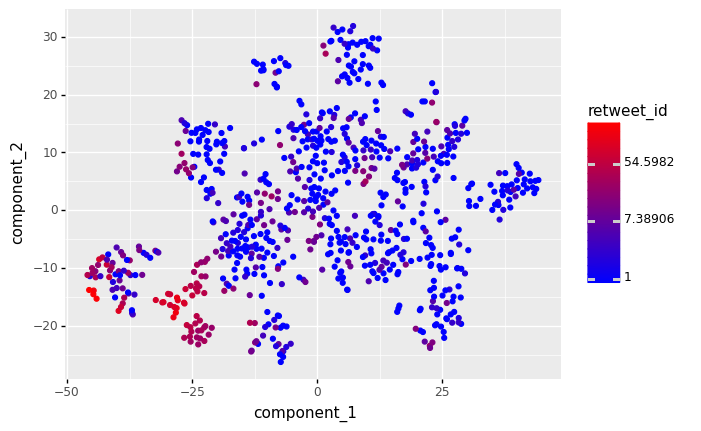

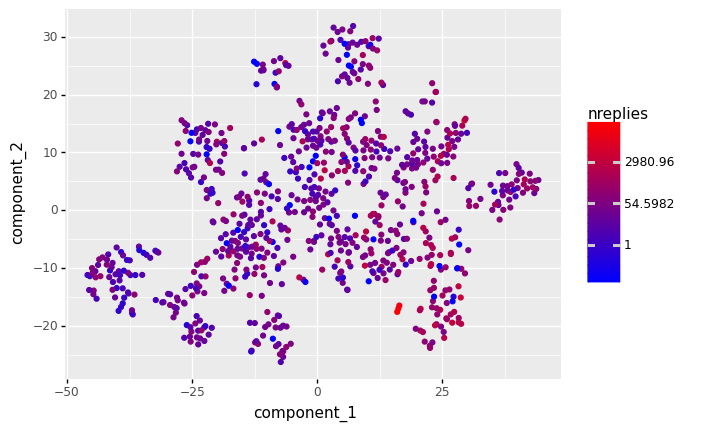

In [41]:
vis_vars = [variables[num] for num in nums]
for variable in vis_vars:
    graph = (
        pn.ggplot(transformed_data, pn.aes(x='component_1', y='component_2', color=variable))
        + pn.geom_point()
        + pn.scale_color_gradient(trans='log', low='blue', high='red')
    )

    graph.draw();

Vemos cómo algunos grupos de puntos tienen un color más unificado que otros. Esto nos permite entender más o menos cómo se construye este mapa en base de las variables originales. Vemos, por ejemplo, que el número de retweets corresponde bien con el eje X.

## Clustering
Vamos a aprovechar de esta reducción de dimensiones para hacer un clustering de los datos. No queremos ir en mucha profunidad de cómo hacer clustering, pero vamos a aprovechar del algoritmo de DBSCAN. Este algoritmo agrupa los puntos en base de una distancia minima entre los puntos y no requiere que especifiquemos un número de clusters apriori.

Lo otro interesante de este algoritmo es que es capaz de identificar que puntos no pertenecen a ningún cluster.

In [42]:
X_variables = ['component_1', 'component_2']

kmeans_tsne_pipeline = Pipeline(
    [
        ('scaler', preprocessing.StandardScaler()),
        ('cluster', DBSCAN(0.21, min_samples=12))
    ]
)

predictions = kmeans_tsne_pipeline.fit_predict(transformed_data[X_variables])
pd.DataFrame(predictions).value_counts()

 4    418
-1     63
 0     58
 6     52
 3     44
 5     42
 7     42
 1     36
 2     25
 8     16
dtype: int64

In [43]:
transformed_data['predictions_clusters'] = predictions.astype(str)

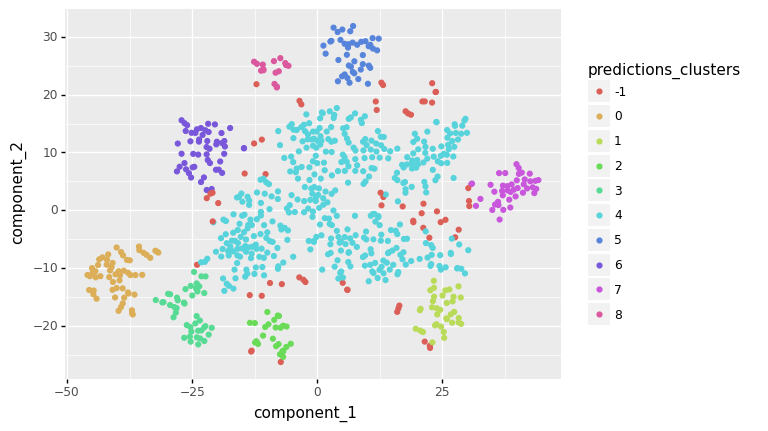

In [44]:
graph = (
    pn.ggplot(transformed_data, pn.aes(x='component_1', y='component_2', color='predictions_clusters'))
    + pn.geom_point()
)

graph.draw();

Dibujando los resultados y vemos que el algoritmo ha sido capaz de identificar unos clusters bastante claros. Parece ser que existe una gran masa de usuaros tipicos en el centro (el cluster 4) y luego tenemos grupos de usuarios en los diferentes lados. Los puntos en rojo (-1) son los que no acaban de pertenecer a ningún grupo especifico.

Y qué son estos clusters? Vamos a analizar los clusters en base de las variables originales:

In [45]:
cols = [col for col in transformed_data if col not in X_variables + ['predictions_clusters']]

In [46]:
transformed_data.groupby('predictions_clusters')[cols].mean()

,following,followers,likes,tweets,media,id,conversation_id,retweet_id,nlikes,nreplies,nretweets,number_hashtags,num_replies_to,num_photos,num_urls,avg_likes,avg_media,followers_per_tweet,num_days_created,bio_length
predictions_clusters,,,,,,,,,,,,,,,,,,,,
-1,108908.142857,9.951656e+06,16912.158730,25930.904762,6025.793651,30.476190,26.555556,3.190476,47739.009036,3261.105002,10730.651613,0.219170,0.162415,0.108798,0.014223,0.705390,0.294508,1873.618377,4264.492063,96.031746
0,7181.379310,8.502608e+06,5875.120690,219199.362069,68559.448276,404.758621,384.844828,28.603448,405.101863,23.456223,63.547951,0.037599,0.037293,0.013458,0.006593,0.040664,0.321893,44.053940,5022.120690,87.327586
1,30805.666667,5.733389e+07,3344.750000,23187.972222,4750.138889,19.500000,15.972222,1.916667,24507.613778,719.627700,2668.886807,0.116969,0.170986,0.079059,0.002022,0.158966,0.215602,5718.351727,4648.805556,52.694444
2,1599.480000,6.466238e+06,62793.800000,21444.600000,2459.120000,19.320000,16.920000,5.440000,2488.448067,59.515245,488.804126,0.106525,0.347957,0.023063,0.002667,3.459508,0.129337,521.130096,4510.760000,81.400000
3,5297.272727,6.311342e+06,14965.113636,61503.659091,6298.386364,112.613636,104.500000,56.886364,748.142289,38.443827,394.543425,0.101523,0.128976,0.029062,0.001151,0.311954,0.103420,214.035846,4509.545455,85.477273
4,2946.031100,5.751678e+06,4001.055024,18326.055024,2615.272727,13.705742,12.760766,2.851675,4322.053329,149.150199,685.847672,0.060752,0.028804,0.034356,0.001443,0.240298,0.194251,1334.323056,4317.495215,78.031100
5,1602.357143,5.699373e+06,3096.857143,16471.309524,2500.595238,8.404762,7.833333,1.761905,1240.278727,64.925482,210.690095,1.561980,0.042456,0.168788,0.003434,0.212075,0.161936,789.012786,4466.880952,87.738095
6,4962.115385,5.796069e+06,10160.865385,29738.788462,2201.500000,36.423077,21.211538,3.711538,2076.487529,71.979587,220.998710,0.026484,1.240510,0.021754,0.000852,0.330579,0.089988,372.164904,4503.750000,75.269231
7,1248.142857,7.451364e+06,3935.309524,13151.047619,2853.904762,7.666667,7.357143,0.833333,3388.077088,105.207429,389.099142,0.127513,0.022583,1.181896,0.006926,0.292872,0.258361,972.470052,4391.309524,72.214286


In [47]:
transformed_data.groupby('predictions_clusters')[vis_vars].mean()

,likes,tweets,media,retweet_id,nreplies
predictions_clusters,,,,,
-1,16912.158730,25930.904762,6025.793651,3.190476,3261.105002
0,5875.120690,219199.362069,68559.448276,28.603448,23.456223
1,3344.750000,23187.972222,4750.138889,1.916667,719.627700
2,62793.800000,21444.600000,2459.120000,5.440000,59.515245
3,14965.113636,61503.659091,6298.386364,56.886364,38.443827
4,4001.055024,18326.055024,2615.272727,2.851675,149.150199
5,3096.857143,16471.309524,2500.595238,1.761905,64.925482
6,10160.865385,29738.788462,2201.500000,3.711538,71.979587
7,3935.309524,13151.047619,2853.904762,0.833333,105.207429


In [48]:
transformed_data.groupby('predictions_clusters')[vis_vars].mean().rank(ascending=False)

,likes,tweets,media,retweet_id,nreplies
predictions_clusters,,,,,
-1,2.0,4.0,3.0,5.0,1.0
0,6.0,1.0,1.0,2.0,10.0
1,9.0,5.0,4.0,7.0,2.0
2,1.0,6.0,9.0,3.0,8.0
3,3.0,2.0,2.0,1.0,9.0
4,7.0,8.0,7.0,6.0,3.0
5,10.0,9.0,8.0,8.0,7.0
6,4.0,3.0,10.0,4.0,6.0
7,8.0,10.0,6.0,10.0,4.0


In [49]:
prct_changes = ((transformed_data.groupby('predictions_clusters')[vis_vars].mean() - transformed_data[vis_vars].mean()) / transformed_data[vis_vars].mean()).reset_index()
graph_data = pd.melt(prct_changes, 'predictions_clusters')

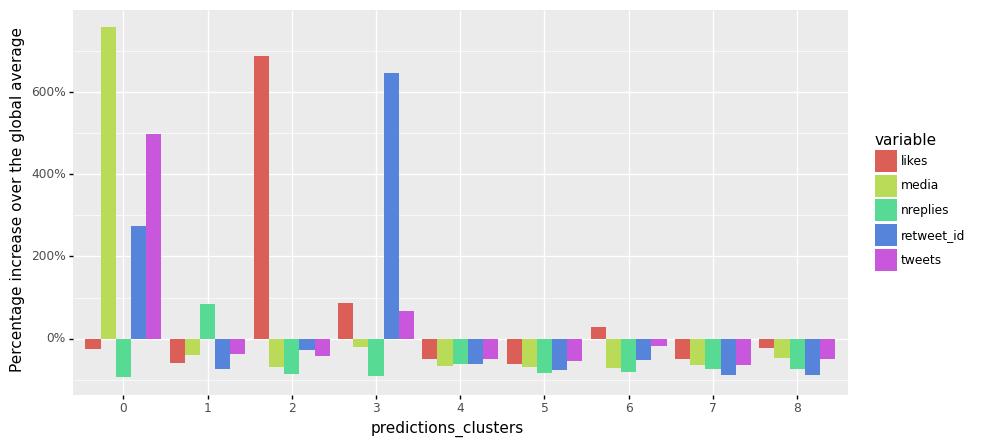

In [50]:
graph = (
    pn.ggplot(graph_data[graph_data.predictions_clusters != '-1'], pn.aes(x='predictions_clusters', y='value', fill='variable'))
    + pn.geom_col(position='dodge')
    + pn.theme(figure_size=(10, 5))
    + pn.scale_y_continuous(labels=percent_format())
    + pn.scale_x_discrete(labels=[str(i) for i in range(graph_data[graph_data.predictions_clusters != '-1'].predictions_clusters.nunique())])
    + pn.ylab('Percentage increase over the global average')
)

graph.draw();

Cogiendo las principales variables que vimos antes, vemos cosas como:

* Muchos de los clusters tienen un valor muy fuerte en alguna variable, como el 2 tiene un número de likes muy por encima de la media, o el 3 retweets, o el 0 con media
* Luego, muchos también tienen una mezcla de cosas únicas, como el 1 teniendo un número regular de todo pero con más "replies" que lo normal, o el 6 con pocos tweeets pero muchos likes

Podemos visualizar las cuentas que se destacan dentro de cada cluster

In [35]:
transformed_data[transformed_data.predictions_clusters == '0'].sort_values('tweets', ascending=False)['name_user'].head()

105                  Slate
8       The New York Times
12                Mashable
15                Fox News
17     The Washington Post
Name: name_user, dtype: object

In [51]:
transformed_data[transformed_data.predictions_clusters == '2'].sort_values('tweets', ascending=False)['name_user'].head()

193          Ricky Gervais
615    Alejandro Vigilante
49           Felicia Day🇺🇸
90              KevinSmith
30            Paulo Coelho
Name: name_user, dtype: object

In [52]:
transformed_data[transformed_data.predictions_clusters == '3'].sort_values('tweets', ascending=False)['name_user'].head()

172                 Perez Hilton
155                  Neil Gaiman
343                 Chad Johnson
705    #مصطفى_الآغا Mustafa Agha
129                   Soulja Boy
Name: name_user, dtype: object

Apreciamos por ejemplo que el 0 son mayormente prensa, el 2 parecen personas famosas del mundo de cultura, mientras y el 10 parecen personas famosas pero por otros temas.